In [38]:
# Import necessary libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# grab the data from google drive
from google.colab import drive
drive.mount('/content/drive')

# Specify a path variable (project path)
proj_path = 'drive/MyDrive/stress/'

# Load the data into a DataFrame
df = pd.read_csv(proj_path + 'Stress.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


Text(0.5, 1.0, 'Distribution of Labels')

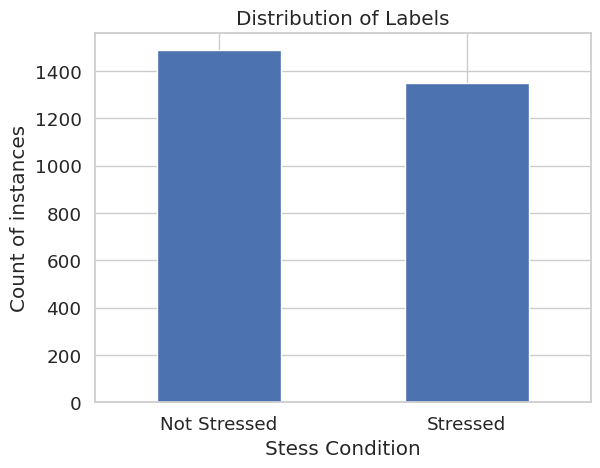

In [40]:
ax = df.label.value_counts().plot(kind='bar')
ax.set_xticks(ticks=[1,0],labels=['Stressed','Not Stressed'],rotation=0)
plt.ylabel('Count of instances')
plt.xlabel('Stess Condition')
plt.title('Distribution of Labels')

[Text(0, 0, 'Not Stressed'), Text(1, 0, 'Stressed')]

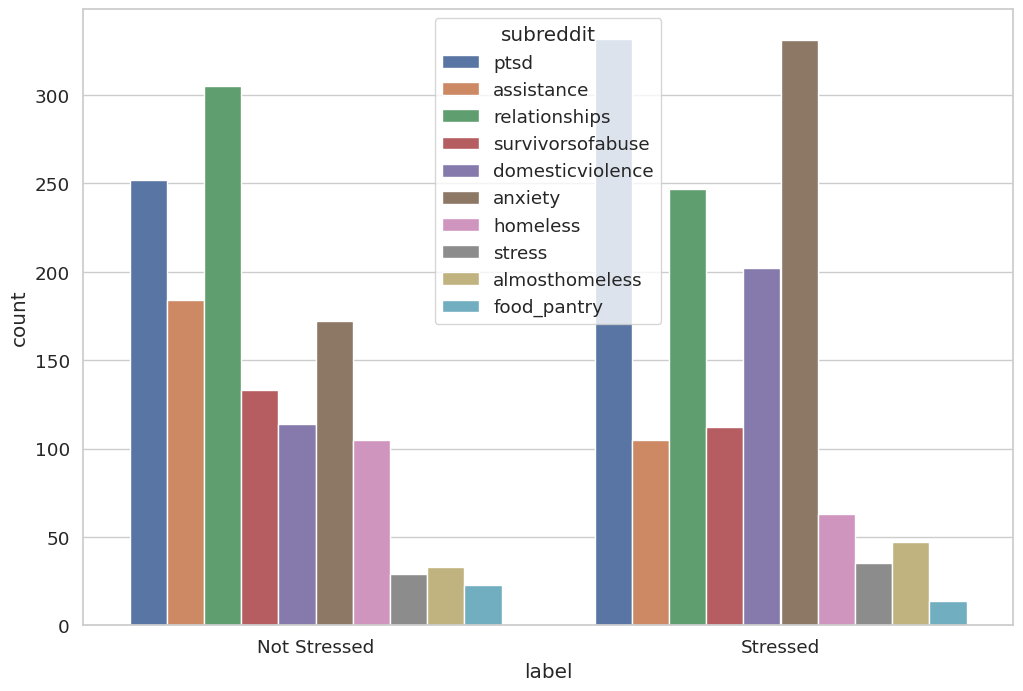

In [41]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "label", hue = "subreddit" , data = df)
#chart.set_xticklabels(chart.get_xticklabels(),rotation=0)
chart.set_xticklabels(labels=['Not Stressed','Stressed'],rotation=0)

In [42]:
not_used_cols = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df1 = df.drop(not_used_cols,axis=1)
df1.sample(3)

,text,label
1260,The problem is is that the kinds of mistakes I...,1
2048,I’ve been in an abusive relationship for 3 yea...,1
2307,I'm going to try not to sound too sad or victi...,0


In [43]:
# Bag Of Words
# Step 1: Preprocess the text data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(texts):
    new_texts = []
    for text in texts:
        # Remove punctuation and special symbols
        text = text.translate(str.maketrans('', '', string.punctuation))

       # Convert text to lowercase
        text = text.lower()

       # Tokenize the text into words
        tokens = word_tokenize(text)

       # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

       # Join the tokens back into a single string
        preprocessed_text = ' '.join(tokens)
        new_texts.append(preprocessed_text)
    return new_texts


texts = df1['text']
preprocessed_texts = preprocess_text(texts)

# Step 2: Tokenization and Create Vocabulary
tokenized_documents = []
vocabulary = set()

for text in preprocessed_texts:
    # Tokenize the text into words
    tokens = text.split()
    tokenized_documents.append(tokens)

    # Update the vocabulary
    vocabulary.update(tokens)

vocabulary = list(vocabulary)


# Step 3: Vectorization
vectorizer = CountVectorizer(vocabulary=vocabulary, binary=True, lowercase=False)
bow_matrix = vectorizer.fit_transform([' '.join(text) for text in tokenized_documents])

# Step 4: Representation
bow_representation = bow_matrix.toarray()
print(bow_representation)








[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [44]:
# Define the target variable
target = df1['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_representation, target, test_size=0.2, random_state=42)

In [45]:
# ML method 1: Logistic Regression based on bag of words

# Initialize and train a Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = logistic_regression_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy:", accuracy)


Accuracy: 0.721830985915493


In [46]:
# ML method 2: SVM based on bag of words
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = svm_model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy:", accuracy)


Accuracy: 0.727112676056338


In [47]:
# Word2Vec

corpus = df1['text']
#Step1: Preprocessing and tokenization
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens

#Step2: Prepare sentences
sentences = [preprocess_text(text) for text in corpus]

#Step 3: Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#Step 4: Test the trained model by a simple word
word_vector = model.wv["books"]
similar_words = model.wv.most_similar("reading")

print("Vector representation of 'books':", word_vector)
print("Similar words to 'reading':", similar_words)


Vector representation of 'books': [-8.14116225e-02  1.67699590e-01  5.63948154e-02  3.14088102e-04
  2.61392444e-03 -3.34579736e-01  7.90906847e-02  4.08348441e-01
 -1.48124173e-01 -1.21753573e-01 -9.84604210e-02 -2.50329077e-01
  3.20965089e-02  5.62801808e-02  5.78791499e-02 -1.58261925e-01
  3.05457376e-02 -1.73569888e-01  4.99257557e-02 -4.39994395e-01
  6.14838786e-02  1.21436551e-01  1.09881110e-01 -6.67851120e-02
 -8.22734162e-02 -1.65079609e-02 -1.77535608e-01 -1.75852254e-01
 -2.06976801e-01 -1.80379841e-02  2.09441870e-01  5.47802746e-02
  5.69704697e-02 -1.40492812e-01 -1.06019907e-01  2.14796245e-01
 -9.13903210e-03 -1.54065654e-01 -1.29676342e-01 -3.35973263e-01
 -8.10544845e-03 -1.91888884e-01 -4.39060591e-02 -2.45084078e-03
  1.69313058e-01 -9.52533558e-02 -1.77481994e-01 -5.67958392e-02
  6.51775226e-02  1.76063746e-01  6.30168244e-02 -1.77334681e-01
 -3.90989855e-02 -2.79861670e-02 -8.90746564e-02  1.18371204e-01
  7.79336244e-02 -4.90362905e-02 -2.24047393e-01  6.8367

In [48]:
# Prepare training data
X = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in sentences])
y = np.array([label for label in df1['label']])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# ML method 1: Logistic Regression based on Word2Vec

# Initialize and train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict labels for test data
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6038732394366197


In [50]:
# ML method 2: SVM based on Word2Vec
svm = SVC()
svm.fit(X_train, y_train)

# Evaluate the model
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.6003521126760564


In [51]:
# ML method 3: CNN based on Word2Vec

# Prepare training data
sentences = [preprocess_text(text) for text in corpus]

# Determine the maximum sequence length
max_length = max(len(sent) for sent in sentences)

# Define the number of classes
num_classes = 2

# Convert sentences to sequences of word indices
sequences = [[model.wv.key_to_index[word] for word in sent if word in model.wv.key_to_index] for sent in sentences]

# Pad sequences to a fixed length
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Prepare training data
X = sequences_padded
y = np.array([label for label in df1['label']])  # Assuming you have corresponding labels for each sentence

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)  # Check the shape of X_train

# Reshape the data
input_shape = (X_train.shape[1],)  # Shape of Word2Vec embeddings

# Define the CNN Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=model.wv.vectors.shape[0], output_dim=model.wv.vectors.shape[1],
                              weights=[model.wv.vectors], input_length=max_length, trainable=False),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

# Predict labels for test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


X_train shape: (2270, 148)
Epoch 1/20
32/32 [==============================] - 2s 11ms/step - loss: 0.6944 - accuracy: 0.5296 - val_loss: 0.6860 - val_accuracy: 0.5242
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5546 - val_loss: 0.6767 - val_accuracy: 0.6300
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6738 - accuracy: 0.5879 - val_loss: 0.6713 - val_accuracy: 0.5815
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6734 - accuracy: 0.5869 - val_loss: 0.6687 - val_accuracy: 0.5859
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.5742 - val_loss: 0.6630 - val_accuracy: 0.6564
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6618 - accuracy: 0.6025 - val_loss: 0.6457 - val_accuracy: 0.6520
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6595 - accuracy: 0.6001 - val_loss: 0.7013 - val_accuracy:

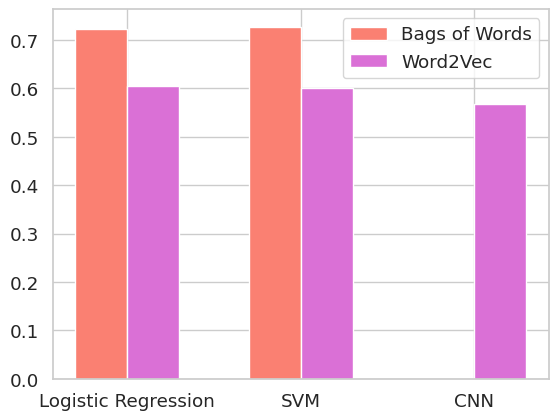

In [53]:
# Data Visualization

x=np.arange(3)
y1=[0.7218, 0.7271, 0]
y2=[0.6038, 0.6003, 0.5686]

bar_width=0.3
tick_label=['Logistic Regression','SVM','CNN']

plt.bar(x,y1,bar_width,color='salmon',label='Bags of Words')
plt.bar(x+bar_width,y2,bar_width,color='orchid',label='Word2Vec')

plt.legend()
plt.xticks(x+bar_width/2,tick_label)
plt.show()